# Introduction:

This a python 3 notebook on how to start segmenting nuclei using a neural network.

* Uses Keras and Tensorflow
* Modified fork of the [Keras U-Net starter notebook](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277)
* Using: [U-Net](https://arxiv.org/abs/1505.04597) architecture
* U-Net architecture is commonly used for image segmentation problems

### Importing dependent libraries:

In [1]:
import os
import sys
import random
import warnings
import types
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras import backend as K
from keras.metrics import binary_crossentropy
from keras.models import model_from_json

import tensorflow as tf

Using TensorFlow backend.


### Initialize some global parameters:

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1024
random.seed = seed
np.random.seed = seed

In [3]:
args = types.SimpleNamespace()
args.data_path = ['./data/']
args.config_file = [' ./model/trained_2018_02_15-18_06_57_config_UNet.json']
args.weights_file = ['./model/trained_2018_02_15-18_06_57_weights_UNet.model']
args.output_dir = ['./model/']

In [4]:
TRAIN_PATH = os.path.join(args.data_path[0]+'/train/')
TEST_PATH = os.path.join(args.data_path[0]+'/test/')

In [5]:
TRAIN_PATH = os.path.join(args.data_path[0]+'/train_aug/')
print (TRAIN_PATH)

./data//train_aug/


### Fetch train and test IDs:

In [6]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Loading data:

* Import all the images and associated masks. 
* Downsample both the training and test images to keep things light and manageable.
* Store the record of the original sizes of the test images to upsample our predicted masks
* Create correct run-length encodings later on using the upsampled data. 

### Fetch and resize training images and masks:

In [ ]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

### Load augmented images:

In [ ]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    for file in os.listdir(path + '/images/'):
        if file.endswith(".png"):
            img_id = (os.path.join(path + '/images/' + str(file)))
        else:
            print ("No image file found ...")
    try:
        img = imread(img_id)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
    except:
        print ("Incompatible image dimensions detected. Resizing image: " + img_id +" ...")
        try:
            img = imread(img_id)[:,:]
            stacked_img = np.stack((img,)*3, -1)
            stacked_img = resize(stacked_img, (IMG_HEIGHT, IMG_WIDTH), \
                                               mode='constant', \
                                               preserve_range=True)
        except:
            print ('Failed to read from image: ' + img_id)
            pass
        X_train[n] = stacked_img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

### Fetch and resize test images:

In [8]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 32.97it/s]


### Save training and test data to disk:

In [ ]:
np.savez_compressed(os.path.join(args.data_path[0]+'/train_aug_256.npz'), xtrain=X_train, ytrain=Y_train)
np.savez_compressed(os.path.join(args.data_path[0]+'/test_256.npz'), xtest=X_test)

### Load saved data from disk:

In [7]:
train_data = np.load(os.path.join(args.data_path[0]+'/train_aug_256.npz'))
X_train = train_data['xtrain']
Y_train = train_data['ytrain']

In [9]:
test_data = np.load(os.path.join(args.data_path[0]+'/test_256.npz'))
X_test = test_data['xtest']

### Running checks on training data

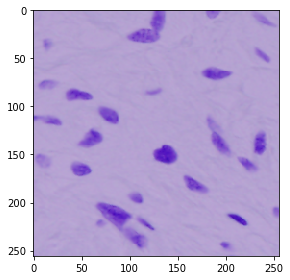

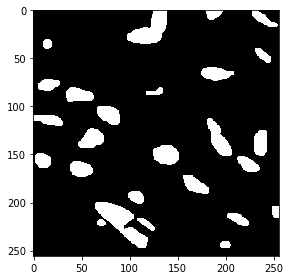

In [10]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Create evaluation metrics:

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

### Kaggle specific IoU metric:

In [11]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### IoU metric using tensorflow:

In [12]:
NUM_CLASSES = 2
def mean_iou_tf(y_true, y_pred):
   score, up_opt = tf.metrics.mean_iou(y_true, y_pred, NUM_CLASSES)
   K.get_session().run(tf.local_variables_initializer())
   with tf.control_dependencies([up_opt]):
       score = tf.identity(score)
   return score

### DICE Coefficient:

In [13]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def bce_dice(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)-K.log(dice_coef(y_true, y_pred))

use_dice = True

In [14]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Create a neural network model for image segmentation:

### U-Net architecture overview:

Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

### Build U-Net model:

In [15]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
DEFAULT_ACTIVATION = 'elu' # 'relu', 'elu'
unit_size = 16
dropout = 0.4

In [16]:
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(unit_size, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(dropout) (c1)
c1 = Conv2D(unit_size, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(unit_size*2, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(dropout) (c2)
c2 = Conv2D(unit_size*2, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(unit_size*4, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(dropout) (c3)
c3 = Conv2D(unit_size*4, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(unit_size*8, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(dropout) (c4)
c4 = Conv2D(unit_size*8, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D((2, 2)) (c4)

c5 = Conv2D(unit_size*16, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(dropout) (c5)
c5 = Conv2D(unit_size*16, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c5)
c5 = Dropout(dropout) (c5)
c5 = Conv2D(unit_size*16, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(unit_size*8, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(unit_size*8, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(dropout) (c6)
c6 = Conv2D(unit_size*8, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(unit_size*4, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(unit_size*4, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(dropout) (c7)
c7 = Conv2D(unit_size*4, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(unit_size*2, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(unit_size*2, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(dropout) (c8)
c8 = Conv2D(unit_size*2, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(unit_size, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(unit_size, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(dropout) (c9)
c9 = Conv2D(unit_size, (3, 3), activation=DEFAULT_ACTIVATION, kernel_initializer='he_normal', padding='same') (c9)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [17]:
model = Model(inputs=[inputs], outputs=[outputs])

In [18]:
def load_prediction_model(args):
    try:
        print (args.config_file[0]) 
        with open(args.config_file[0]) as json_file:
              model_json = json_file.read()
        model = model_from_json(model_json)
        return model
    except:
        print ("Please specify a model configuration file ...")
        sys.exit(1)
        
def load_prediction_model_weights(args):
    try:
        model.load_weights(args.weights_file[0])
        print ("Loaded model weights from: " + str(args.weights_file[0]))
        return model
        
    except:
        print ("Error loading model weights ...")
        sys.exit(1)

In [19]:
load_from_checkpoint = False
load_model = False
load_model_weights = True
if load_from_checkpoint == True:
    if use_dice == True:
        model = load_model(os.path.join(args.output_dir[0]+'/checkpoint/UNet_dsbowl2018.h5'), \
                       custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef, 'bce_dice': bce_dice})
    else:
        model = load_model(os.path.join(args.output_dir[0]+'/checkpoint/UNet_dsbowl2018.h5'), \
                       custom_objects={'mean_iou': mean_iou})
elif load_model == True:
    model = load_prediction_model(args)
    model = load_prediction_model_weights(args)
elif load_model_weights == True:
    model = load_prediction_model_weights(args)
else:
    model = model

Loaded model weights from: ./model/trained_2018_02_15-18_06_57_weights_UNet.model


### Select optimizer:

In [20]:
sgd = SGD(lr=1e-7, decay=0.5, momentum=1, nesterov=True)
rms = RMSprop(lr=1e-7, rho=0.9, epsilon=1e-08, decay=0.0)
ada = Adagrad(lr=1e-3, epsilon=1e-08, decay=0.0)
adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
DEFAULT_OPTIMIZER = ada

### Compile model and generate summary:

In [21]:
use_dice = False
use_dice_loss = True
if use_dice ==True:
    model.compile(optimizer = DEFAULT_OPTIMIZER, 
              loss = bce_dice, 
              metrics = ['binary_crossentropy', dice_coef, mean_iou])
elif use_dice_loss ==True:
    model.compile(optimizer = DEFAULT_OPTIMIZER, 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])
else:
    model.compile(optimizer=DEFAULT_OPTIMIZER, loss='binary_crossentropy', metrics=[mean_iou])

In [22]:
model_summary = True
if model_summary == True:
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

### Visualize model architecture:

In [ ]:
from keras.utils import plot_model 
import pydot 
import graphviz # apt-get install -y graphviz libgraphviz-dev 
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot

In [ ]:
plot_model(model, to_file= os.path.join(args.output_dir[0] + '/model.png')) 
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Fit model:

* Model architecture uses ELU units, 
* Additional dropout layers to manage over-fitting.
* Fit the model on the training data, using a validation split:train split of 0.1. 
* Small batch size because due to small sized dataset. 
* Checkpointing and early stopping during training of the model.

In [23]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(os.path.join(args.output_dir[0]+'checkpoint/UNet_dsbowl2018.h5'),\
                               verbose=1,\
                               save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, 
                    callbacks=[earlystopper, checkpointer])

Train on 4824 samples, validate on 536 samples
Epoch 1/25
4824/4824 [==============================] - 5192s 1s/step - loss: -0.7599 - dice_coef: 0.7599 - acc: 0.9130 - mean_squared_error: 0.0869 - val_loss: -0.8356 - val_dice_coef: 0.8356 - val_acc: 0.9510 - val_mean_squared_error: 0.0490

Epoch 00001: val_loss improved from inf to -0.83561, saving model to ./model/checkpoint/UNet_dsbowl2018.h5
Epoch 2/25
4824/4824 [==============================] - 5133s 1s/step - loss: -0.8393 - dice_coef: 0.8393 - acc: 0.9499 - mean_squared_error: 0.0500 - val_loss: -0.8450 - val_dice_coef: 0.8450 - val_acc: 0.9543 - val_mean_squared_error: 0.0457

Epoch 00002: val_loss improved from -0.83561 to -0.84501, saving model to ./model/checkpoint/UNet_dsbowl2018.h5
Epoch 3/25
4824/4824 [==============================] - 5157s 1s/step - loss: -0.8469 - dice_coef: 0.8469 - acc: 0.9521 - mean_squared_error: 0.0478 - val_loss: -0.8474 - val_dice_coef: 0.8474 - val_acc: 0.9549 - val_mean_squared_error: 0.0450


Epoch 24/25
4824/4824 [==============================] - 7328s 2s/step - loss: -0.8648 - dice_coef: 0.8648 - acc: 0.9578 - mean_squared_error: 0.0422 - val_loss: -0.8652 - val_dice_coef: 0.8652 - val_acc: 0.9601 - val_mean_squared_error: 0.0399

Epoch 00024: val_loss improved from -0.86474 to -0.86521, saving model to ./model/checkpoint/UNet_dsbowl2018.h5
Epoch 25/25
4824/4824 [==============================] - 7330s 2s/step - loss: -0.8649 - dice_coef: 0.8649 - acc: 0.9578 - mean_squared_error: 0.0421 - val_loss: -0.8655 - val_dice_coef: 0.8655 - val_acc: 0.9603 - val_mean_squared_error: 0.0396

Epoch 00025: val_loss improved from -0.86521 to -0.86555, saving model to ./model/checkpoint/UNet_dsbowl2018.h5


# Save model to disk:

In [ ]:
def generate_timestamp():
    timestring = time.strftime("%Y_%m_%d-%H_%M_%S")
    print ("Time stamp generated: "+timestring)
    return timestring

In [ ]:
timestr = generate_timestamp()

In [ ]:
def save_model(args, name, model):
    file_loc = args.output_dir[0]
    file_pointer = os.path.join(file_loc+"//trained_"+ timestr)
    model.save_weights(os.path.join(file_pointer + "_weights"+str(name)+".model"))    
    model_json = model.to_json()
    with open(os.path.join(file_pointer+"_config"+str(name)+".json"), "w") as json_file:
        json_file.write(model_json)
    print ("Saved the trained model weights to: " + 
           str(os.path.join(file_pointer + "_weights"+str(name)+".model")))
    print ("Saved the trained model configuration as a json file to: " + 
    str(os.path.join(file_pointer+"_config"+str(name)+".json")))

In [ ]:
save_model(args, '_UNet', model)

# Retrain the model:

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(os.path.join(args.output_dir[0]+'checkpoint/UNet_dsbowl2018_2.h5'),\
                               verbose=1,\
                               save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=67, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

# Load saved model:

In [ ]:
load_from_checkpoint = False
load_model = False
load_model_weights = True
if load_from_checkpoint == True:
    if use_dice == True:
        model = load_model(os.path.join(args.output_dir[0]+'/checkpoint/UNet_dsbowl2018.h5'), \
                       custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef, 'bce_dice': bce_dice})
    else:
        model = load_model(os.path.join(args.output_dir[0]+'/checkpoint/UNet_dsbowl2018.h5'), \
                       custom_objects={'mean_iou': mean_iou})
elif load_model == True:
    model = load_prediction_model(args)
    model = load_prediction_model_weights(args)
elif load_model_weights == True:
    model = load_prediction_model_weights(args)
else:
    model = model

#  Generate predictions:

### Run predictions on train, validation and test:

In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

### Threshold predictions:

In [ ]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

### Create list of upsampled test masks:

In [ ]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

### Visual comparison of predictions with random training samples:

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

###  Visual comparison of predictions against random validation samples:

In [ ]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Encode and submit results:

* To submit our results, the output needs run-length encoding. 
* This notebook uses run-length encoding function described [here](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python).

### Run-length encoding:

In [ ]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

### Generate a complete submission:
Iterate through test IDs to generate run-length encodings for each seperate mask:

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

### Create submission data frame:

In [ ]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./sub-dsbowl2018-UNet_20180212_05.csv', index=False)

### Notes for improvements the results:

* Adjust hyper-parameters, 
* Tweaking the architecture a little bit
* Train the model for a longer duration with early stopping

**Have fun!**